An adversary can leverage a membership inference attack that takes advantage of query answers on a sequestered dataset to infer if a particular individual exists in the sequestered dataset.
There are situations in which knowing if an individual exists within a sequestered dataset poses risk to the individual. 

The membership attacks in this notebook come from [DSSUV'15, Robust Traceability from Trace Amounts.](https://privacytools.seas.harvard.edu/files/privacytools/files/robust.pdf)

This notebook makes use of the Public Use Microdata Sample (PUMS), obtained from the Census Bureau’s American Community Survey (ACS).
Attacks like the one demonstrated in this notebook motivate the use of statistical disclosure limitation techniques like differential privacy.

In [ ]:
import numpy as np
import pandas as pd
import time
np.random.seed(123)

### Membership Attacks

An attacker wants to determine if Alice, an individual from the population, is a member of a sequestered dataset.
Consider the sequestered dataset to be a sample from a broader population.

It is assumed that the attacker is given the answers to a mean query mechanism applied to the sequestered dataset.
The attacker collects the public information for Alice, as well as the public information for other individuals from the population (the reference sample). 

The gist of the attack is that if Alice is more similar to the query answers than the reference sample is to the query answers, then Alice is likely a member of the sequestered dataset.

The first attack comes from figure 1, where the reference sample is assumed to be of size 1.

In [ ]:
def membership_attack_fig_1(individual, answers, reference_samples, delta=.05):
    """Perform membership attack using dwork et al. test statistic.
    See figure 1 in https://privacytools.seas.harvard.edu/files/privacytools/files/robust.pdf

    :param individual: y, a boolean vector of shape (d,)
    :param answers: q, a float vector with elements in [0, 1] of shape (d,)
    :param reference_samples: z, a boolean vector of length (1, d)
    :param delta: statistical significance
    :return: True if alice is in data with (1-delta)100% confidence."""
    individual = individual * 2 - 1
    answers = answers * 2 - 1
    reference_samples = reference_samples * 2 - 1

    alice_similarity = np.dot(individual, answers) # cosine similarity
    reference_similarity = np.dot(reference_samples[0], answers)
    statistic = alice_similarity - reference_similarity
    
    d = len(individual)
    tau = np.sqrt(8 * d * np.log(1 / delta))
    return statistic > tau

The second attack comes from figure 2, a generalization of figure 1 where the reference sample is larger. While the implementation is not as intuitive, it has greater power than figure 1.

In [ ]:
def membership_attack_fig_2(individual, answers, reference_samples, delta=.05):
    """Perform membership attack using dwork et al. test statistic.
    See figure 2 in https://privacytools.seas.harvard.edu/files/privacytools/files/robust.pdf

    :param individual: y, a boolean vector of shape (d,)
    :param answers: q, a float vector with elements in [0, 1] of shape (d,)
    :param reference_samples: z, a boolean vector of length (*, d)
    :param delta: statistical significance
    :return: True if alice is in data with (1-delta)100% confidence."""
    individual = individual * 2 - 1
    answers = answers * 2 - 1
    reference_samples = reference_samples * 2 - 1

    z, w = reference_samples[0], reference_samples[1:].mean(axis=0)
    m, d = reference_samples[1:].shape
    
    alpha = np.sqrt(1 / m)
    eta = 2 * alpha
    
    statistic = np.dot(individual - z, np.clip(answers - w, -eta, eta))
    tau = 4 * alpha * np.sqrt(d * np.log(1 / delta))
    
    return statistic > tau

Both of these attacks have low power compared to a Monte Carlo simulation of the null distribution.

### Example

In the following examples, we will consider the population to be 100 individuals from the PUMS dataset. For simplicity, we are assuming all columns are public. Since the tests expect boolean data, we also provide a function to project from a real dataset to a boolean predicate space. We'll be conducting our tests on the projected boolean space.

In [ ]:
population: pd.DataFrame = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5sample100.csv")


def make_boolean_projection(d_in, d_out=1):
    """Returns a (pseudo)random vector predicate function by hashing data."""
    prime = 691
    desc = np.random.randint(prime, size=(d_in, d_out))
    # this predicate maps data into a ndarray of booleans of size [n, d_out]
    #   (where `@` is the dot product and `%` modulus)
    return lambda data: ((data.values @ desc) % prime % 2).astype(bool)


def draw(data: pd.DataFrame, sample_size: int):
    """Returns `sample_size` rows randomly from `data`, and the rest"""
    indices = np.arange(len(population))
    np.random.shuffle(indices)
    return population.iloc[indices[:sample_size]], population.iloc[indices[sample_size:]]


def execute_exact_query(data):
    """Computes the mean of each attribute."""
    return data.mean(axis=0)


To set up this problem, we'll first create a sequestered dataset, sampled from the population.
In practice, this sequestered dataset may be from, for example, a medical trial, or polls conducted by a political party. In those cases, the selection mechanism isn't a simple sample, and the strength of the attack may be increased.

In [ ]:
sequestered_data, rest = draw(population, 10)

At this point the attacker takes over. 
The attacker builds a projection that maps data into a boolean space in which the tests can be conducted. 
He then collects the information he needs- public information for Alice, query answers on the sequestered data, and reference samples from the population. 
Keep in mind that the attacker does not need access to the sequestered data to retrieve the public information for Alice and the reference samples.

If the membership attack evaluates to True, then the attacker can be 95% confident that Alice is a member of the sequestered dataset.
If the membership attack evaluates to False, it is inconclusive if Alice is a member of the sequestered dataset.

In [ ]:
# Projects the real-valued dataset into a boolean space with `d_out` columns
project = make_boolean_projection(len(population.columns), d_out=4000)

# Attacker computes the means of each of the attributes of the data in the projected space
# An attacker can still execute this attack on a query interface via predicates
answers = execute_exact_query(project(sequestered_data))

# Attacker collects a reference sample from the population
reference_samples = project(population.sample(1))

# Attacker collects public info for Alice
alice = project(sequestered_data.sample(1))[0]

membership_attack_fig_1(
    individual=alice, 
    answers=answers, 
    reference_samples=reference_samples, 
    delta=.05)

True

The following example is similar, but we expect the test not to pass, because Anita is not a member of the sequestered dataset.

In [ ]:
# Attacker collects public info for Anita
anita = project(rest.sample(1))[0]

membership_attack_fig_1(
    individual=anita, 
    answers=answers, 
    reference_samples=reference_samples, 
    delta=.05)

False

### Simulations

In the following simulations, we will conduct the membership attack thousands of times on different sequestered datasets, random projections, choices of alice, and reference samples, to see how the attack performs as we vary the predicate space dimensionality.

In [ ]:
def simulate_attacks(
    query,
    membership_attack, delta,
    sample_size, reference_size, 
    num_predicates, num_trials):
    """Simulates `membership_attack` many times for different boolean space dimensionalities.

    :param query: a function that maps data to query answers
    :param membership_attack: either membership_attack_fig_1 or membership_attack_fig_2
    :param delta: statistical significance of the result
    :param sample_size: number of records to sample for the sequestered dataset
    :param reference_size: number of referents to sample from the population
    :param num_predicates: A vector of boolean space dimensionalities to test
    :param num_trials: number of membership attacks to conduct for each boolean space dimensionality
    :return: Tuple[np.ndarray, np.ndarray]; A vector false positive rates, and a vector of true positive rates
    """
    fp_results = []
    tp_results = []

    for d in num_predicates:
        fp = 0
        tp = 0

        print('Predicate space dimensionality:', d)

        start_time = time.time()
        for i in range(num_trials):
            if i % (num_trials // 10) == 0:
                print(f"{i / num_trials:.0%} ", end="")

            # split the population into the sequestered data, and the rest
            sequestered_data, rest = draw(population, sample_size)

            # build new projection each trial (which contains new random predicates)
            projection = make_boolean_projection(len(population.columns), d)

            # answers to queries on the dataset to be attacked
            answers = query(projection(sequestered_data))

            # collect a reference sample from the population
            reference_samples = projection(rest.sample(reference_size))

            # collect an individual from the attacked dataset
            alice = projection(sequestered_data.sample(1))[0]
            tp += membership_attack(
                individual=alice, answers=answers, 
                reference_samples=reference_samples, delta=delta)

            # collect an individual from the population
            anita = projection(rest.sample(1))[0]
            fp += membership_attack(
                individual=anita, answers=answers, 
                reference_samples=reference_samples, delta=delta)

        print(f"100% ~ {round(time.time() - start_time)} seconds (tp:{tp},fp:{fp})")
        fp_results.append(fp / num_trials)
        tp_results.append(tp / num_trials)
    return fp_results, tp_results


def plot_fpr_tpr(num_predicates, fp_results, tp_results):
    import matplotlib.pyplot as plt
    plt.plot(num_predicates, fp_results)
    plt.xlabel("Number of Predicates")
    plt.ylabel("False Positive Rate")
    plt.ylim(bottom=0., top=1.)
    plt.title("False Positive Rate as Number of Predicates Increases")
    plt.show()

    plt.plot(num_predicates, tp_results)
    plt.xlabel("Number of Predicates")
    plt.ylabel("True Positive Rate")
    plt.ylim(bottom=0., top=1.)
    plt.title("True Positive Rate as Number of Predicates Increases")
    plt.show()

In this attack we use the membership attack from figure 1, and vary the predicate space to up to 1000 predicates.

Predicate space dimensionality: 200
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 4 seconds (tp:1,fp:0)
Predicate space dimensionality: 400
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 5 seconds (tp:84,fp:0)
Predicate space dimensionality: 600
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 5 seconds (tp:496,fp:0)
Predicate space dimensionality: 800
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 6 seconds (tp:897,fp:0)
Predicate space dimensionality: 1000
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 6 seconds (tp:995,fp:0)
FPR [0.0, 0.0, 0.0, 0.0, 0.0]
TPR [0.001, 0.084, 0.496, 0.897, 0.995]


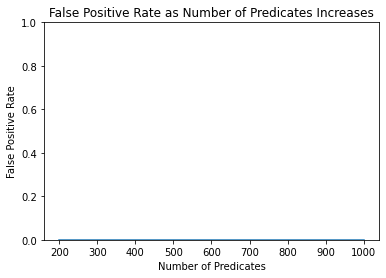

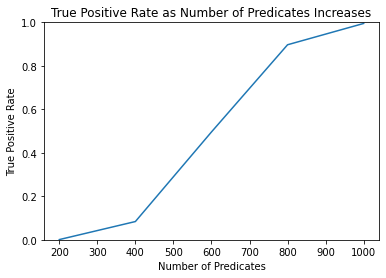

In [ ]:
num_predicates = np.arange(1, 6) * len(population) * 2
fp_results, tp_results = simulate_attacks(
    execute_exact_query,
    membership_attack_fig_1, 
    sample_size=5,
    reference_size=1, 
    num_predicates=num_predicates, 
    num_trials=1000,
    delta=0.05)
print("FPR", fp_results)
print("TPR", tp_results)

plot_fpr_tpr(num_predicates, fp_results, tp_results)

The test doesn't identify members outside of the sequestered dataset (false positive rate of zero), and becomes more powerful as the number of predicates increases (true positive rate increasing).

These results look very significant, but keep in mind that the size of the sequestered dataset `sample_size` is only 5. Such a small sample size makes the query answers more distinctive, thus making it much easier to distinguish Alice.

In this second simulation, we increase the sample size to a relatively large 30% of the population. In order to maintain power on the membership attack, we use the hypothesis test from figure 2 instead, collect a larger reference sample, and increase the number of predicates.

Predicate space dimensionality: 200
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 7 seconds (tp:11,fp:0)
Predicate space dimensionality: 400
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 8 seconds (tp:36,fp:0)
Predicate space dimensionality: 600
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 11 seconds (tp:108,fp:0)
Predicate space dimensionality: 800
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 13 seconds (tp:165,fp:0)
Predicate space dimensionality: 1000
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 14 seconds (tp:304,fp:0)
Predicate space dimensionality: 1200
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 17 seconds (tp:383,fp:0)
Predicate space dimensionality: 1400
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 19 seconds (tp:473,fp:0)
Predicate space dimensionality: 1600
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 20 seconds (tp:593,fp:0)
Predicate space dimensionality: 1800
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 31 seconds (tp:682,fp:0)
Predicate space dimensionality: 2000

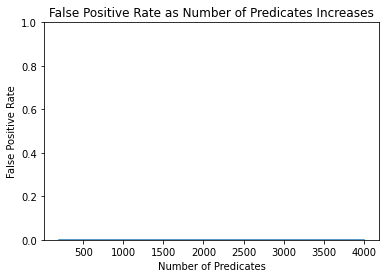

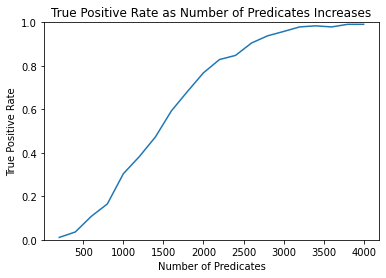

In [ ]:
# Run a more powerful attack with a much larger sample_size and more predicates
num_predicates = np.arange(1, 21) * len(population) * 2
fp_results, tp_results = simulate_attacks(
    execute_exact_query,
    membership_attack_fig_2, 
    sample_size=30,
    reference_size=50, 
    num_predicates=num_predicates,
    num_trials=1000,
    delta=0.05)

print("FPR", fp_results)
print("TPR", tp_results)
plot_fpr_tpr(num_predicates, fp_results, tp_results)

The attack is more than effectively demonstrated at 4000 predicates, which gives an ~0% FPR and >80% TPR. It is trivial to increase the number of predicates or size of the reference sample to further increase the power of the attack.


### Differential Privacy

We now adjust our query interface to return answers protected by differential privacy. 
`execute_dp_query` releases an estimate of the mean for each predicate.
The implementation splits the budget evenly over all input columns.
By linear composition, the total privacy expenditure of the joint release of all means works out to be `epsilon`. 
As the number of attributes increases, the number of queries increases, which commensurately increases the noise scale.

In [ ]:
from opendp.measurements import make_base_laplace
from opendp.mod import binary_search_param, enable_features
from opendp.transformations import make_sized_bounded_mean
from opendp.typing import *

from functools import lru_cache

enable_features("floating-point", "contrib")

epsilon = 1.

@lru_cache(maxsize=None)
def find_scale(size, num_queries):
    epsilon_per = epsilon / num_queries
    mean = make_sized_bounded_mean(size=size, bounds=(0., 1.))
    return binary_search_param(
        lambda s: mean >> make_base_laplace(s), 
        d_in=2, d_out=epsilon_per)


def execute_dp_query(data):
    """Computes the dp means of `data`.
    Assumes the number of rows is public information 
    The total privacy expenditure is `epsilon`."""
    exact_aggregates = data.mean(axis=0)
    scale = find_scale(*data.shape)

    base_laplace = make_base_laplace(scale, D=VectorDomain[AllDomain[float]])
    return np.array(base_laplace(exact_aggregates))


Lets run the simulation once more with this new query interface.

Predicate space dimensionality: 200
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 14 seconds (tp:495,fp:493)
Predicate space dimensionality: 400
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 20 seconds (tp:504,fp:489)
Predicate space dimensionality: 600
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 29 seconds (tp:511,fp:503)
Predicate space dimensionality: 800
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 36 seconds (tp:505,fp:494)
Predicate space dimensionality: 1000
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 43 seconds (tp:490,fp:502)
Predicate space dimensionality: 1200
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 51 seconds (tp:515,fp:489)
Predicate space dimensionality: 1400
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 58 seconds (tp:520,fp:511)
Predicate space dimensionality: 1600
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 66 seconds (tp:500,fp:504)
Predicate space dimensionality: 1800
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% ~ 73 seconds (tp:506,fp:500)
Predicate spac

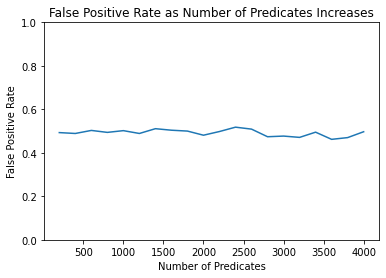

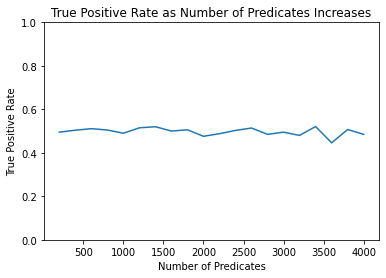

In [ ]:
num_predicates = np.arange(1, 21) * len(population) * 2
fp_results, tp_results = simulate_attacks(
    execute_dp_query,
    membership_attack_fig_1, 
    sample_size=5,
    reference_size=1, 
    num_predicates=num_predicates, 
    num_trials=1000,
    delta=0.05)
print("FPR", fp_results)
print("TPR", tp_results)

plot_fpr_tpr(num_predicates, fp_results, tp_results)

The resulting graphs show that the membership attack is thwarted. The response from the test is practically a coin-flip; it fails to identify Alice as a member of the sequestered dataset about half the time, and falsely identifies Anita as a member of the dataset about half the time.